# 将图片中的object切出然后推理
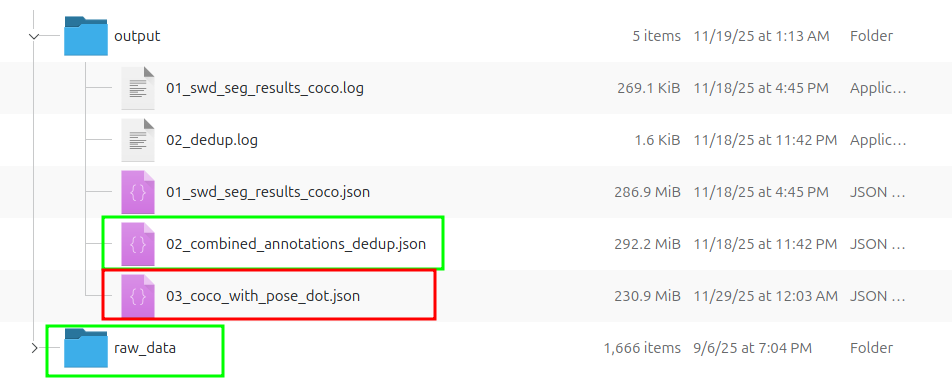
```json
{
    "info": {
        "description": "SWD COCO format instance segmentation with pose and dot annotations",
        "version": "1.0",
        "year": 2025,
        "contributor": "Tianqi Yao",
    },
    "licenses": [
        {
            "id": 1, 
            "name": "CC BY-NC 4.0",
            "url": "https://creativecommons.org/licenses/by-nc/4.0/"
        }
    ],
    "images": [
        {
            "id": 100,
            "file_name": "0730_1834_760.jpg",
            "width": 640,
            "height": 480,
            "license": 1,
            "date_captured": "2024-07-30T18:34:00-05:00",  // ISO 8601 format, US central time
            "focal_length_parameter": 760
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 100,
            "category_id": 1,
            "object_id": "", // UUID string
            "score": 0.92,
            "segmentation": [[x1, y1, x2, y2, ...]],  // pixel coordinates
            "area": 1032.0,
            "bbox": [x, y, width, height],  //  pixel coordinates
            "iscrowd": 0,
            "keypoints": [x1, y1, v1, x2, y2, v2, x3, y3, v3], // v=0: not labeled, v=1: labeled but not visible, v=2: labeled and visible
            "num_keypoints": 3,
            "attributes": {
                "dot_detections": [
                    {
                        "bbox": [x1, y1, w1, h1],  // pixel coordinates
                        "score": 0.95,
                        "category_id": 2,
                    },
                    {
                        "bbox": [x2, y2, w2, h2],  // pixel coordinates
                        "score": 0.87,
                        "category_id": 2,
                    }
                ]
            }
        }
    ],
    "categories": [
        {
            "id": 1,
            "name": "swd",
            "supercategory": "object",
            "keypoints": ["h", "lp", "rp"],
            "skeleton": [[0, 1], [0, 2]]
        },
        {
            "id": 2,
            "name": "dot", 
            "supercategory": "object"
        }
    ]
}
```

In [1]:
# ============================utils============================
from __future__ import annotations

from pathlib import Path
from typing import Dict, Any, List

import logging
import json
import cv2
import numpy as np
from ultralytics import YOLO

# ==== 时区：美国中部 ====
from datetime import datetime
from zoneinfo import ZoneInfo

CENTRAL_TZ = ZoneInfo("US/Central")


def central_time(*args):
    """让 logging 使用美国中部时间."""
    return datetime.now(CENTRAL_TZ).timetuple()


# 全局 logger（非 basicConfig 风格）
LOGGER = logging.getLogger(__name__)


def configure_logging_for_directory(
    base_dir: Path,
    log_file_name: str = "pose_dot.log",
    level: str = "INFO",
) -> None:
    """
    为当前 base_dir 配置日志：
    - 日志文件路径：base_dir / log_file_name
    - 同时输出到控制台
    - 不使用 basicConfig，手动添加 handler
    """
    base_dir.mkdir(parents=True, exist_ok=True)
    log_path = base_dir / log_file_name

    # 设置日志级别
    log_level = getattr(logging, level.upper(), logging.INFO)
    LOGGER.setLevel(log_level)

    # 统一格式 & 时区
    formatter = logging.Formatter(
        fmt="%(asctime)s [%(levelname)s] %(name)s - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
    )
    logging.Formatter.converter = central_time

    # 先移除并关闭现有 handler，避免重复写多次
    for handler in LOGGER.handlers[:]:
        LOGGER.removeHandler(handler)
        handler.close()

    # 控制台输出
    console_handler = logging.StreamHandler()
    console_handler.setLevel(log_level)
    console_handler.setFormatter(formatter)
    LOGGER.addHandler(console_handler)

    # 文件输出
    file_handler = logging.FileHandler(log_path, mode="w", encoding="utf-8")
    file_handler.setLevel(log_level)
    file_handler.setFormatter(formatter)
    LOGGER.addHandler(file_handler)

    LOGGER.info("Logging configured. Base directory: %s", base_dir)
    LOGGER.info("Log path: %s", log_path)


def free_gpu():
    import gc, torch
    gc.collect()                    # 触发 Python 垃圾回收
    torch.cuda.empty_cache()        # 释放未使用的 GPU 缓存到驱动
    torch.cuda.ipc_collect()        # 清理跨进程缓存（偶尔有用）


def _fix_imgsz(model: YOLO, imgsz):
    """
    YOLO 不允许 imgsz=None。
    若 imgsz=None，则：
        1. 尝试读取 model.overrides["imgsz"]
        2. 若仍然为 None，则 fallback 到 640
    """
    if imgsz is None:
        ms = model.overrides.get("imgsz", None)
        if ms is None:
            # fallback
            return 640
        return ms
    return imgsz


# ============================核心函数============================

def run_pose_on_one_crop(
    model: YOLO,
    crop_img: np.ndarray,
    kpt_names: List[str],
    predict_args: Dict[str, Any],
) -> Dict[str, Any]:
    """
    返回 crop 中所有虫子的姿态，每个虫子一个 dict：
    {
        "instances": [
            {
                "keypoints": [...],
                "num_keypoints": int,
                "pose_bbox_score": float | None,
                "pose_keypoint_score": [float | None],
            },
            ...
        ]
    }
    """
    results = model.predict(source=crop_img, **predict_args)
    if not results:
        return {"instances": []}

    res = results[0]
    instances = []

    # ---- bbox scores（所有虫子）----
    boxes = getattr(res, "boxes", None)
    if boxes is not None and getattr(boxes, "conf", None) is not None:
        bbox_conf_arr = boxes.conf.cpu().numpy()
    else:
        bbox_conf_arr = None

    # ---- keypoints（所有虫子）----
    kpts = getattr(res, "keypoints", None)
    if kpts is None or kpts.data is None:
        return {"instances": []}

    arr = kpts.data.cpu().numpy()
    conf_arr = getattr(kpts, "conf", None)
    conf_arr = conf_arr.cpu().numpy() if conf_arr is not None else None

    num_insects = arr.shape[0]

    for idx in range(num_insects):
        pts = arr[idx]

        keypoints = []
        num_keypoints = 0
        kpt_scores = []

        for ki in range(min(len(kpt_names), pts.shape[0])):
            x, y = float(pts[ki][0]), float(pts[ki][1])

            conf = None
            if conf_arr is not None:
                conf = float(conf_arr[idx][ki])
                visibility = 2 if conf > 0.5 else 1
            else:
                visibility = 2

            keypoints.extend([x, y, visibility])
            kpt_scores.append(conf)

            if visibility == 2:
                num_keypoints += 1

        bbox_score = (
            float(bbox_conf_arr[idx]) if bbox_conf_arr is not None else None
        )

        instances.append({
            "keypoints": keypoints,
            "num_keypoints": num_keypoints,
            "pose_bbox_score": bbox_score,
            "pose_keypoint_score": kpt_scores,
        })

    return {"instances": instances}




def run_dot_det_on_one_crop(
    model: YOLO,
    crop_img: np.ndarray,
    predict_args: Dict[str, Any],
) -> Dict[str, Any]:
    """
    对单个 crop 图跑小黑点 det，返回 COCO 格式的点检测结果：
    {
        "dot_detections": [
            {
                "bbox": [x, y, w, h],  # COCO bbox format
                "score": float,
                "category_id": 2,  # 固定为 dot 类别
            },
            ...
        ]
    }
    """
    results = model.predict(source=crop_img, **predict_args)
    if not results:
        return {"dot_detections": []}

    res = results[0]
    dot_detections: List[Dict[str, Any]] = []

    boxes = getattr(res, "boxes", None)
    if boxes is not None:
        xywh = boxes.xywh.cpu().numpy() if hasattr(boxes, "xywh") else None
        confs = (
            boxes.conf.cpu().numpy()
            if hasattr(boxes, "conf") and boxes.conf is not None
            else None
        )

        if xywh is not None:
            n = xywh.shape[0]
            for i in range(n):
                x, y, w, h = map(float, xywh[i].tolist())  # 这是yolo的 xywh 格式, 需要转换为 COCO bbox 格式
                x_coco = x - w / 2
                y_coco = y - h / 2
                conf_score = float(confs[i]) if confs is not None and i < len(confs) else 0.0
                dot_detections.append(
                    {
                        "bbox": [x_coco, y_coco, w, h],
                        "score": conf_score,
                        "category_id": 2,  # dot 类别固定为 2
                    }
                )

    return {"dot_detections": dot_detections}


# ==== mark final swd ====
def point_in_box(px: float, py: float, box):
    """
    判断像素点 (px, py) 是否在 bbox 内
    box: [x, y, w, h]  像素坐标（COCO 格式）
    """
    x, y, w, h = box
    return (px >= x) and (px <= x + w) and (py >= y) and (py <= y + h)

def mark_final_swd_for_ann(ann: Dict[str, Any]) -> None:
    """
    根据当前 annotation 中的 keypoints 和 attributes.dot_detections，
    判断该虫子是否为 final swd，并写入：
        ann["attributes"]["is_final_swd"] = True / False

    规则：lp 和 rp 都至少命中一个 dot bbox。
    """
    # keypoints: [x1, y1, v1, x2, y2, v2, x3, y3, v3]
    kps = ann.get("keypoints", [])
    if not kps or len(kps) < 9:
        ann.setdefault("attributes", {})["is_final_swd"] = False
        return

    # kpt_names = ["h", "lp", "rp"]
    # index 映射：h -> 0, lp -> 1, rp -> 2
    lp_x, lp_y = kps[3], kps[4]   # 第 2 个点
    rp_x, rp_y = kps[6], kps[7]   # 第 3 个点

    attrs = ann.setdefault("attributes", {})
    dot_list = attrs.get("dot_detections", [])

    if not dot_list:
        attrs["is_final_swd"] = False
        return

    # dot_list 里已经是像素坐标 bbox
    lp_hit = any(point_in_box(lp_x, lp_y, d["bbox"]) for d in dot_list)
    rp_hit = any(point_in_box(rp_x, rp_y, d["bbox"]) for d in dot_list)

    attrs["is_final_swd"] = bool(lp_hit and rp_hit)


# ============================主函数============================

def attach_pose_and_dot_in_memory(
    coco_json_path: Path,
    images_root: Path,
    output_json_path: Path,
    pose_model_path: str,
    dot_model_path: str,
    margin: int = 15,
):
    """
    不在磁盘上保存 crop 小图，直接在内存中按 bbox 截图并跑 pose / dot，
    只在 annotations 中添加 keypoints, num_keypoints, attributes.dot_detections 字段。
    """
    # ---- 读 COCO ----
    with coco_json_path.open("r", encoding="utf-8") as f:
        coco = json.load(f)

    images = coco["images"]
    annotations = coco["annotations"]

    # image_id -> list[ann]
    anns_by_image: Dict[int, List[Dict[str, Any]]] = {}
    for ann in annotations:
        anns_by_image.setdefault(ann["image_id"], []).append(ann)

    # ---- 加载模型一次 ----
    LOGGER.info("Loading pose model from: %s", pose_model_path)
    pose_model = YOLO(pose_model_path)
    pose_args = {
        "imgsz": _fix_imgsz(pose_model, None),
        "conf": 0.5,  # 0.88 best for swd pose val set， 0.88 -> 0.5 for more recall
        "iou": 0.6,
        "device": 0,
        "verbose": False,
        "batch": 1,
    }

    LOGGER.info("Loading dot model from: %s", dot_model_path)
    dot_model = YOLO(dot_model_path)
    dot_args = {
        "imgsz": _fix_imgsz(dot_model, None),
        "conf": 0.1,
        "iou": 0.5,
        "device": 0,
        "verbose": False,
        "batch": 1,
    }

    kpt_names = ["h", "lp", "rp"]

    total_anns = 0
    pose_ok = 0
    dot_ok = 0

    # ---- 遍历每张原图，只读一次 ----
    for img_info in images:
        img_id = img_info["id"]
        file_name = img_info["file_name"]
        width = img_info["width"]
        height = img_info["height"]

        img_path = images_root / file_name
        if not img_path.exists():
            LOGGER.warning("Image file not found, skip: %s", img_path)
            continue

        img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        if img is None:
            LOGGER.warning("cv2 failed to read image, skip: %s", img_path)
            continue

        anns = anns_by_image.get(img_id, [])
        if not anns:
            continue

        LOGGER.info("Processing image %s with %d objects", file_name, len(anns))

        for ann in anns:
            total_anns += 1

            bbox = ann["bbox"]  # [x, y, w, h] in COCO
            x, y, w, h = bbox
            # 加 margin 的裁剪框（确保不越界）
            x1 = max(0, int(x - margin))
            y1 = max(0, int(y - margin))
            x2 = min(width, int(x + w + margin))
            y2 = min(height, int(y + h + margin))

            if x2 <= x1 or y2 <= y1:
                # bbox 异常，写空结果
                LOGGER.debug("Invalid bbox for image %s, ann id %s, write empty result", file_name, ann.get("id"))
                ann["keypoints"] = []
                ann["num_keypoints"] = 0
                ann.setdefault("attributes", {})["dot_detections"] = []
                continue

            crop = img[y1:y2, x1:x2].copy()

            # -------- pose：直接得到 COCO 格式的关键点 --------
            pose_local = run_pose_on_one_crop(
                model=pose_model,
                crop_img=crop,
                kpt_names=kpt_names,
                predict_args=pose_args,
            )

            # 按照置信度取第一个虫子
            pose_local["instances"].sort(key=lambda x: x.get("pose_bbox_score", 0) or 0, reverse=True)

            pose_local = pose_local["instances"][0] if pose_local["instances"] else {  # 取第一个虫子
                "keypoints": [],
                "num_keypoints": 0,
                "pose_bbox_score": None,
                "pose_keypoint_score": [],
            }

            # 将局部坐标的关键点转换为原图坐标
            keypoints_global = pose_local["keypoints"].copy()
            for i in range(0, len(keypoints_global), 3):
                # 只要坐标不是 (0, 0) 就平移
                if keypoints_global[i] != 0 or keypoints_global[i + 1] != 0:
                    keypoints_global[i] += x1    # x
                    keypoints_global[i + 1] += y1  # y

            # 更新 annotation 的 keypoints
            ann["keypoints"] = keypoints_global
            ann["num_keypoints"] = pose_local["num_keypoints"]
            ann["pose_confidence"] = pose_local["pose_keypoint_score"]
            ann["pose_bbox_score"] = pose_local["pose_bbox_score"]

            if pose_local["num_keypoints"] > 0:
                pose_ok += 1

            # -------- dot det：直接得到 COCO 格式的点检测 --------
            dot_local = run_dot_det_on_one_crop(
                model=dot_model,
                crop_img=crop,
                predict_args=dot_args,
            )

            # 将局部坐标的点检测转换为原图坐标
            dot_detections_global: List[Dict[str, Any]] = []
            for dot_det in dot_local["dot_detections"]:
                x_dot, y_dot, w_dot, h_dot = dot_det["bbox"]
                dot_detections_global.append(
                    {
                        "bbox": [x_dot + x1, y_dot + y1, w_dot, h_dot],
                        "score": dot_det["score"],
                        "category_id": dot_det["category_id"],
                    }
                )

            # 更新 annotation 的 attributes
            ann.setdefault("attributes", {})["dot_detections"] = dot_detections_global

            if dot_detections_global:
                dot_ok += 1

            mark_final_swd_for_ann(ann)

    # ---- 确保 categories swd 类别中包含 pose 关键点信息 ----
    swd_category = {
        "id": 1,
        "name": "swd",
        "supercategory": "object",
        "keypoints": ["h", "lp", "rp"],
        "skeleton": [[0, 1], [0, 2]],  # h->lp, h->rp
    }

    # ---- 确保 categories 包含 dot 类别 ----
    dot_category = {
        "id": 2,
        "name": "dot",
        "supercategory": "object",
    }

    if "categories" not in coco:
        coco["categories"] = [swd_category, dot_category]
    else:
        # 更新现有的 categories
        updated_categories = []
        for cat in coco["categories"]:
            if cat["id"] == 1:  # swd 类别
                cat["keypoints"] = swd_category["keypoints"]
                cat["skeleton"] = swd_category["skeleton"]
            updated_categories.append(cat)

        # 确保包含 swd 和 dot 类别
        existing_cat_ids = {cat["id"] for cat in updated_categories}
        if 1 not in existing_cat_ids:
            updated_categories.append(swd_category)
        if 2 not in existing_cat_ids:
            updated_categories.append(dot_category)

        coco["categories"] = updated_categories

    # ---- 保存结果 ----
    output_json_path.parent.mkdir(parents=True, exist_ok=True)
    with output_json_path.open("w", encoding="utf-8") as f:
        json.dump(coco, f, indent=2, ensure_ascii=False)

    LOGGER.info("Processing finished")
    LOGGER.info("  Total annotations: %d", total_anns)
    LOGGER.info("  With pose results: %d", pose_ok)
    LOGGER.info("  With dot results:  %d", dot_ok)
    LOGGER.info("  Output JSON:       %s", output_json_path)

In [2]:
# ============================获取子目录============================
from pathlib import Path

def fetch_subsequent_dir(data_root: Path, target_subdir_name: Path, depth: int):
    data_paths = list(data_root.glob(f"{'*/' * depth}{target_subdir_name}"))
    # display(data_paths)
    # get sub dir - no target_subdir_name
    subdir_path_list = [data_path.parent for data_path in data_paths]
    # display(subdir_path_list)
    subdir_name_list = [subdir.name for subdir in subdir_path_list]
    # display(subdir_name_list)
    return subdir_path_list, subdir_name_list


# data_root = Path("/workspace/_ty/01_data/00_test/00_try")
# depth = 0
data_root = Path("/workspace/_ty/01_data/01_16mp_2024_pipeline_data")
depth = 1

target_subdir_name = Path("raw_data")
subdir_path_list, subdir_name_list = fetch_subsequent_dir(data_root, target_subdir_name, depth=depth)
display(subdir_path_list)
display(subdir_name_list)
len(subdir_path_list), len(subdir_name_list)

[PosixPath('/workspace/_ty/01_data/01_16mp_2024_pipeline_data/ms2_0726-0809_13_ok'),
 PosixPath('/workspace/_ty/01_data/01_16mp_2024_pipeline_data/sw1_0605-0613_07_ok'),
 PosixPath('/workspace/_ty/01_data/01_16mp_2024_pipeline_data/ms1_0809-0823_34_ok'),
 PosixPath('/workspace/_ty/01_data/01_16mp_2024_pipeline_data/ms1_0710-0726_36_ok'),
 PosixPath('/workspace/_ty/01_data/01_16mp_2024_pipeline_data/sw1_0711-0725_03_ok'),
 PosixPath('/workspace/_ty/01_data/01_16mp_2024_pipeline_data/ms1_0605-0621_40_ok'),
 PosixPath('/workspace/_ty/01_data/01_16mp_2024_pipeline_data/jeff_0613-0624_04_ok'),
 PosixPath('/workspace/_ty/01_data/01_16mp_2024_pipeline_data/lloyd_0715-0729_04_ok'),
 PosixPath('/workspace/_ty/01_data/01_16mp_2024_pipeline_data/ms2_0809-0823_10_ok'),
 PosixPath('/workspace/_ty/01_data/01_16mp_2024_pipeline_data/ms1_0726-0809_11_ok'),
 PosixPath('/workspace/_ty/01_data/01_16mp_2024_pipeline_data/sw2_0808-0823_04_ok')]

['ms2_0726-0809_13_ok',
 'sw1_0605-0613_07_ok',
 'ms1_0809-0823_34_ok',
 'ms1_0710-0726_36_ok',
 'sw1_0711-0725_03_ok',
 'ms1_0605-0621_40_ok',
 'jeff_0613-0624_04_ok',
 'lloyd_0715-0729_04_ok',
 'ms2_0809-0823_10_ok',
 'ms1_0726-0809_11_ok',
 'sw2_0808-0823_04_ok']

(11, 11)

In [3]:
# ===========================执行===================

for subdir_path, subdir_name in zip(subdir_path_list, subdir_name_list):
    # 每个子目录单独一个 log 文件
    configure_logging_for_directory(
        base_dir=subdir_path,
        log_file_name="pose_dot.log",  # 你可以改名字
        level="INFO",
    )

    LOGGER.info("==== Processing dataset subdir: %s ====", subdir_name)

    COCO_JSON_PATH = subdir_path / "output" / "02_combined_annotations_dedup.json"
    IMAGES_ROOT = subdir_path / "raw_data"
    OUTPUT_COCO_JSON = subdir_path / "output" / "03_coco_with_pose_dot.json"

    attach_pose_and_dot_in_memory(
        coco_json_path=COCO_JSON_PATH,
        images_root=IMAGES_ROOT,
        output_json_path=OUTPUT_COCO_JSON,
        pose_model_path="/workspace/_ty/05_models/best_models/02_swd_pose/yolo11n-pose-best_v2.pt",
        dot_model_path="/workspace/_ty/05_models/best_models/03_dot_det/yolo11n-det-best_v1.pt",
        margin=0,   # crop margin, 原来是15
    )

    free_gpu()

    # 如果你只想先测试第一个子目录，可以保留 break
    # break

2025-11-28 23:15:01 [INFO] __main__ - Logging configured. Base directory: /workspace/_ty/01_data/01_16mp_2024_pipeline_data/ms2_0726-0809_13_ok
2025-11-28 23:15:01 [INFO] __main__ - Log path: /workspace/_ty/01_data/01_16mp_2024_pipeline_data/ms2_0726-0809_13_ok/pose_dot.log
2025-11-28 23:15:01 [INFO] __main__ - ==== Processing dataset subdir: ms2_0726-0809_13_ok ====
2025-11-28 23:15:03 [INFO] __main__ - Loading pose model from: /workspace/_ty/05_models/best_models/02_swd_pose/yolo11n-pose-best_v2.pt
2025-11-28 23:15:03 [INFO] __main__ - Loading dot model from: /workspace/_ty/05_models/best_models/03_dot_det/yolo11n-det-best_v1.pt
2025-11-28 23:15:03 [INFO] __main__ - Processing image 0727_0603_540.jpg with 18 objects
2025-11-28 23:15:05 [INFO] __main__ - Processing image 0727_0604_580.jpg with 25 objects
2025-11-28 23:15:05 [INFO] __main__ - Processing image 0727_0605_600.jpg with 30 objects
2025-11-28 23:15:05 [INFO] __main__ - Processing image 0727_0607_640.jpg with 30 objects
2025-